In [85]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [86]:
import glob
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import *
from models.gan import ResNetDiscriminator, StyleVectorizer, Projector
from data_funcs import *
from utils.logger import Logger
import utils.gan_utils as gan_utils

In [87]:
RUN_PADPAF = "../outputs/id=padpaf/task=damnist-fedgan/lr=0.001_0.01/seed=123/model/*"
RUN_PADPAF_COND = "../outputs/id=padpaf/task=damnist-fedgan-conditional-partial/lr=0.001_0.01/seed=123/model/*"
# RUN_PADPAF2 = "../outputs/id=padpaf-nostylesim/task=damnist-fedgan/lr=0.001_0.01/seed=123/model/*"
# RUN_PADPAF2_COND = "../outputs/id=padpaf-nostylesim/task=damnist-fedgan-conditional-partial/lr=0.001_0.01/seed=123/model/*"

MODEL_PATHS = RUN_PADPAF_COND

In [88]:
conditional = "conditional" in MODEL_PATHS

In [89]:
# model_paths = glob.glob("models/partial/normal/model_round*.pth.tar")
def get_round(model_path):
    return int(model_path[-11:-8])

model_paths = glob.glob(MODEL_PATHS)
# model_paths = sorted(model_paths, key=lambda pth: get_round(pth))  # sort by round
for p in model_paths: print(p)

../outputs/id=padpaf/task=damnist-fedgan-conditional-partial/lr=0.001_0.01/seed=123/model/model.pth.tar


## Init setting and model

In [90]:
Logger.setup_logging("INFO", logfile="")
Logger()

image_size = 32
channels = 3

dataset_name = "damnist"
data_path = "../data/"
num_workers = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_classes = 10

batch_size = 32
lr = 1e-3
epochs = 50
lr_gamma = 0.95

In [91]:
loader_kwargs = {}
if not device == 'cpu':
    loader_kwargs["num_workers"] = num_workers
    loader_kwargs["persistent_workers"] = num_workers > 0

In [92]:
_, test_dataset = load_data(dataset=dataset_name, path=data_path)

## Load test dataset

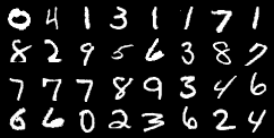

tensor([0, 4, 1, 3, 1, 1, 7, 1], device='cuda:0')
tensor([8, 2, 9, 5, 6, 3, 8, 7], device='cuda:0')
tensor([7, 7, 7, 8, 9, 3, 4, 6], device='cuda:0')
tensor([6, 6, 0, 2, 3, 6, 2, 4], device='cuda:0')


In [94]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, **loader_kwargs)
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5+0.5*x))))
    for i in range(0, y.size(0), 8):
        print(y[i:i+8])
    break

## Load model

In [95]:
def init_styleD(num_features=64):
     return ResNetDiscriminator(num_features=num_features, image_size=image_size, channels=channels)


def init_style_map(num_latents=128):
     return StyleVectorizer(num_latents, 8, lr_mul=0.1)


def init_style_proj(hidden_dim=64):
     return Projector(hidden_dim, 2 * hidden_dim)


def init_model(num_latents=128, num_features=64):
    return FedGAN(num_latents=num_latents,
                             D_features=num_features, G_features=num_features,
                             image_size=image_size, channels=channels, num_classes=num_classes if conditional else 0)

global_model = init_model().to(device)

In [96]:
def moving_avg(series, t=1):
    return series
    ###
    avgs = []
    for i in range(1, len(series) + 1):
        last_t = series[:i][-t:]
        avg = sum(last_t) / len(last_t)
        avgs.append(avg)
    return avgs


def load_fedgan_all_styles(global_model, fp, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'])
    global_model.content_proj.load_state_dict(state_dict['content_proj'])
    private_modules = []
    for worker_id in range(len(state_dict)):
        if str(worker_id) not in state_dict:
            continue
        # Local modules
        local_state_dict = state_dict[str(worker_id)]
        # TODO: can't we just deepcopy from global_model? (write copy() method)
        styleD = init_styleD().to(device)
        styleD.load_state_dict(local_state_dict['styleD'])
        style_map = init_style_map().to(device)
        style_map.load_state_dict(local_state_dict['style_map'])
        style_proj = init_style_proj(styleD.hidden_dim)
        style_proj.load_state_dict(local_state_dict['style_proj'])
        style_modules = {
            "id": worker_id,
            "styleD": styleD,
            "style_map": style_map,
            "style_proj": style_proj,
        }
        private_modules.append(style_modules)
    return global_model, private_modules

## Train a latent transform from representation (one style)

In [97]:
def make_transform(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, in_features),
        nn.BatchNorm1d(in_features),
        nn.ReLU(),
        nn.Linear(in_features, out_features),
    )

In [98]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)
[m["id"] for m in private_modules]

[0, 1, 2, 3, 4, 5, 6, 7]

In [14]:
content_transform = make_transform(global_model.contentD.num_features, global_model.num_latents).to(device)
style_transform = make_transform(global_model.styleD.num_features, global_model.num_latents).to(device)
optim = torch.optim.Adam([{'params': content_transform.parameters()}, {'params': style_transform.parameters()}], lr=lr)
sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=lr_gamma)

In [15]:
losses = []
for epoch in range(epochs):
    mean_loss = 0.0
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            _, style_features = global_model.styleD(x, return_h=True)
        # Transform representations to latents
        content_latent = content_transform(content_features)
        style_latent = style_transform(style_features)
        fake = global_model.G(content_latent, global_model.style_map(style_latent), label=y)
        ###### Loss ######
        loss_type = 2
        if loss_type == 1:
            loss = F.mse_loss(fake, x)
        elif loss_type == 2:
            _, fake_content_features = global_model.contentD(fake, return_h=True)
            _, fake_style_features = global_model.styleD(fake, return_h=True)
            loss = F.mse_loss(fake_content_features, content_features) + F.mse_loss(fake_style_features, style_features)
        elif loss_type == 3:
            loss = F.l1_loss(fake, x)
        elif loss_type == 4:
            _, fake_content_features = global_model.contentD(fake, return_h=True)
            _, fake_style_features = global_model.styleD(fake, return_h=True)
            loss = F.l1_loss(fake, x) + F.mse_loss(fake_content_features, content_features) + F.mse_loss(fake_style_features, style_features)
        # Calculate loss and optimize
        optim.zero_grad(); loss.backward(); optim.step()
        mean_loss += loss.item() / len(test_loader)
    # Record epoch mean loss and acc
    losses.append(mean_loss)
    print(f"[{epoch+1}/{epochs}] "
          f"loss = {mean_loss:4f}\t"
         )
    sched.step()

[1/50] loss = 0.155950	
[2/50] loss = 0.125332	
[3/50] loss = 0.115904	
[4/50] loss = 0.109900	
[5/50] loss = 0.105369	
[6/50] loss = 0.101675	
[7/50] loss = 0.098682	
[8/50] loss = 0.096334	
[9/50] loss = 0.094262	
[10/50] loss = 0.092519	
[11/50] loss = 0.090981	
[12/50] loss = 0.089660	
[13/50] loss = 0.088444	
[14/50] loss = 0.087377	
[15/50] loss = 0.086406	
[16/50] loss = 0.085462	
[17/50] loss = 0.084691	
[18/50] loss = 0.083858	
[19/50] loss = 0.083212	
[20/50] loss = 0.082580	
[21/50] loss = 0.082023	
[22/50] loss = 0.081451	
[23/50] loss = 0.080918	
[24/50] loss = 0.080513	
[25/50] loss = 0.080029	
[26/50] loss = 0.079628	
[27/50] loss = 0.079262	


KeyboardInterrupt: 

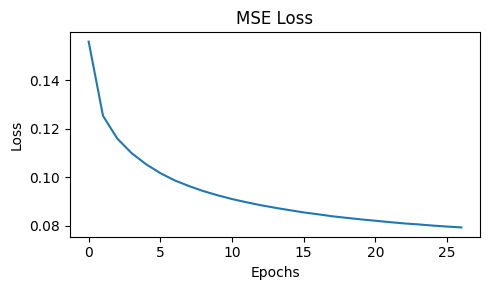

In [16]:
plt.figure()
plt.plot(np.array(moving_avg(losses)))
plt.title("MSE Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_all_styles.pdf")

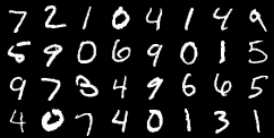

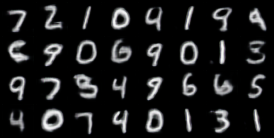

In [17]:
def show_sample(t):
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5*t+0.5))))


x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

show_sample(x)

# Get features from discriminators
with torch.no_grad():
    _, content_features = global_model.contentD(x, return_h=True)
    _, style_features = global_model.styleD(x, return_h=True)
    # Transform representations to latents
    content_latent = content_transform(content_features)
    style_latent = style_transform(style_features)
    fake = global_model.G(content_latent, global_model.style_map(style_latent), label=y)

show_sample(fake)

## Self-training for transfer to all styles (transforming directly to style, not style latent)

In [99]:
num_samples_per_epoch = 40

In [100]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)
private_modules = sorted(private_modules, key=lambda m: m['id'])
[m["id"] for m in private_modules]

[0, 1, 2, 3, 4, 5, 6, 7]

In [101]:
def make_transform(in_features, out_features, depth=8):
    layers = []
    for _ in range(depth):
        layers += [
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
        ]

    return nn.Sequential(*layers, nn.Linear(in_features, out_features))

In [102]:
content_transform = make_transform(global_model.contentD.num_features, global_model.num_latents).to(device)

# style_transform = make_transform(global_model.styleD.num_features, global_model.num_latents).to(device)
# param_groups = [{'params': content_transform.parameters()}, {'params': style_transform.parameters()}]

for m in private_modules:
    m['transform'] = make_transform(global_model.styleD.num_features, global_model.num_latents).to(device)
param_groups = [{'params': content_transform.parameters()}] + [{'params': m['transform'].parameters()} for m in private_modules]

optim = torch.optim.Adam(param_groups, lr=lr)
sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=lr_gamma)

print(sum(p.numel() for p in content_transform.parameters()))

42624


In [103]:
def sim(proj, h1, h2):

    def off_diagonal(x):
        return x.flatten()[:-1].view(x.size(0) - 1, x.size(0) + 1)[:, 1:].flatten()

    z1, z2 = proj(h1), proj(h2)
    C = z1.T @ z2 / z1.size(0)
    on_diag = torch.diagonal(C).add_(-1).pow_(2).sum()
    off_diag = off_diagonal(C).pow_(2).sum()
    output = on_diag + 0.005 * off_diag
    return output

In [104]:
losses = []
for epoch in range(epochs):
    mean_loss = 0.0
    for _ in range(num_samples_per_epoch):
        # Sample label
        y = torch.randint(num_classes, (batch_size,)).to(device) if conditional else None
        for client in range(len(private_modules)):
            # Generate target image
            with torch.no_grad():
                x_content_latent = torch.randn(batch_size, global_model.num_latents).to(device)
                x_style_latent = torch.randn(batch_size, global_model.num_latents).to(device)
                x_style = private_modules[client]['style_map'](x_style_latent)
                x = global_model.G(x_content_latent, x_style , label=y)

            # Get representation of target image
            with torch.no_grad():
                _, content_features = global_model.contentD(x, return_h=True)
                _, style_features = private_modules[client]['styleD'](x, return_h=True)

            # Transform representations to latents
            content_latent = content_transform(content_features)
            style_latent = private_modules[client]['transform'](style_features)
            style = private_modules[client]['style_map'](style_latent)
            fake = global_model.G(content_latent, style, label=y)

            ###### Loss ######
            _, fake_content_features = global_model.contentD(fake, label=y, return_h=True)
            _, fake_style_features = global_model.styleD(fake, return_h=True)
            loss = sim(global_model.content_proj, content_features, fake_content_features)
            # loss += sim(global_model.style_proj, style_features, fake_style_features)

            # Calculate loss and optimize
            optim.zero_grad(); loss.backward(); optim.step()
            mean_loss += loss.item() / len(test_loader)
    # Record epoch mean loss and acc
    losses.append(mean_loss)
    print(f"[{epoch+1}/{epochs}] "
          f"loss = {mean_loss:4f}\t"
         )
    sched.step()

[1/50] loss = 29.689492	
[2/50] loss = 16.898790	
[3/50] loss = 13.768345	
[4/50] loss = 11.674915	
[5/50] loss = 10.767084	
[6/50] loss = 9.935061	
[7/50] loss = 9.591027	
[8/50] loss = 9.148537	
[9/50] loss = 9.021835	
[10/50] loss = 8.446014	
[11/50] loss = 8.271499	
[12/50] loss = 8.016714	
[13/50] loss = 7.975618	
[14/50] loss = 7.706790	
[15/50] loss = 7.946348	
[16/50] loss = 7.567568	
[17/50] loss = 7.394674	
[18/50] loss = 7.311537	
[19/50] loss = 7.277972	
[20/50] loss = 7.033747	
[21/50] loss = 6.933893	
[22/50] loss = 6.956188	
[23/50] loss = 6.815298	
[24/50] loss = 6.893427	
[25/50] loss = 6.932297	
[26/50] loss = 6.757809	
[27/50] loss = 6.621174	
[28/50] loss = 6.681243	
[29/50] loss = 6.643902	
[30/50] loss = 6.609427	
[31/50] loss = 6.608783	
[32/50] loss = 6.412914	
[33/50] loss = 6.386214	
[34/50] loss = 6.322523	
[35/50] loss = 6.293439	
[36/50] loss = 6.352048	
[37/50] loss = 6.404353	
[38/50] loss = 6.329867	
[39/50] loss = 6.236040	
[40/50] loss = 6.402583	
[41/

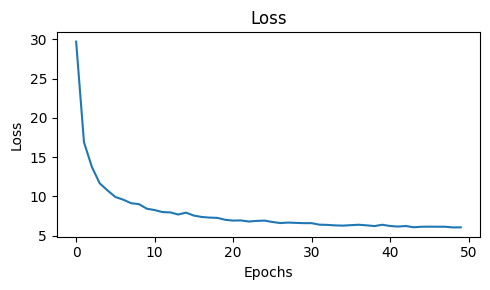

In [105]:
plt.figure()
plt.plot(np.array(moving_avg(losses)))
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_predictlatent.pdf")

Target (client 7):


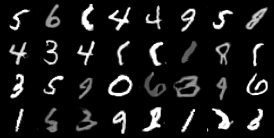

Generated (client 7):


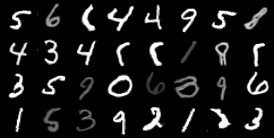

Generated (client 2):


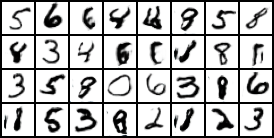

In [106]:
def show_sample(t):
    im = Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5*t+0.5)))
    display(im)
    return im


# Sample target image
client = torch.randint(8, (1,)).item()
ref_client = torch.randint(8, (1,)).item()
client = 7
ref_client = 2
y = torch.randint(num_classes, (batch_size,)).to(device) if conditional else None

with torch.no_grad():
    x_content_latent = torch.randn(batch_size, global_model.num_latents).to(device)
    x_style_latent = torch.randn(batch_size, global_model.num_latents).to(device)
    x_style = private_modules[client]['style_map'](x_style_latent)
    x = global_model.G(x_content_latent, x_style , label=y)
print(f"Target (client {client}):")
show_sample(x).save(f"results/transfer{'_cond' if conditional else ''}_source{client:02d}.pdf")

with torch.no_grad():
    _, content_features = global_model.contentD(x, return_h=True)
    _, style_features = private_modules[client]['styleD'](x, return_h=True)
    # Transform representations to latents
    content_latent = content_transform(content_features)
    style_latent = private_modules[client]['transform'](style_features)
    style = private_modules[client]['style_map'](style_latent)
    fake = global_model.G(content_latent, style, label=y)
print(f"Generated (client {client}):")
show_sample(fake).save(f"results/transfer{'_cond' if conditional else ''}_source{client:02d}_recon.pdf")

with torch.no_grad():
    ref_style_latent = torch.randn(batch_size, global_model.num_latents).to(device)
    ref_style = private_modules[ref_client]['style_map'](ref_style_latent)
    ref_fake = global_model.G(content_latent, ref_style, label=y)
print(f"Generated (client {ref_client}):")
show_sample(ref_fake).save(f"results/transfer{'_cond' if conditional else ''}_source{client:02d}_style{ref_client:02d}.pdf")

Target (test):


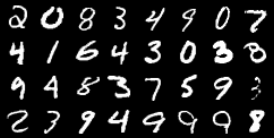

Generated (client 0):


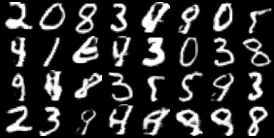

Generated (client 1):


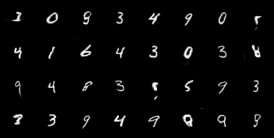

Generated (client 2):


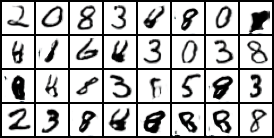

Generated (client 3):


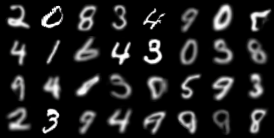

Generated (client 4):


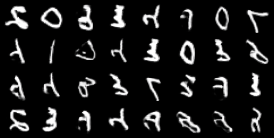

Generated (client 5):


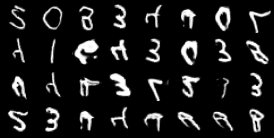

Generated (client 6):


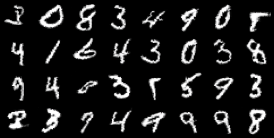

Generated (client 7):


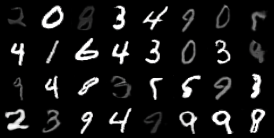

In [107]:
# Sample target image
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)
if not conditional:
    y = None

client = 0  # rough estimate

print(f"Target (test):")
show_sample(x).save(f"results/transfer{'_cond' if conditional else ''}_sourcetest.pdf")

with torch.no_grad():
    # Transform representations to latents
    _, content_features = global_model.contentD(x, return_h=True)
    _, style_features = private_modules[client]['styleD'](x, return_h=True)
    content_latent = content_transform(content_features)
    for ref_client in range(len(private_modules)):
        ref_style_latent = torch.randn(batch_size, global_model.num_latents).to(device)
        ref_style = private_modules[ref_client]['style_map'](ref_style_latent)
        ref_fake = global_model.G(content_latent, ref_style, label=y)
        print(f"Generated (client {ref_client}):")
        show_sample(ref_fake).save(f"results/transfer{'_cond' if conditional else ''}_sourcetest_style{ref_client:02d}.pdf")